Nama : Kety Nandini

NIM : 22.11.4595

In [ ]:
!pip install pyspark

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.sql.functions import col, count, mean,min, max
from pyspark.sql.functions import isnan, when, count, regexp_replace, udf
from pyspark.sql.types import DoubleType, IntegerType
from pyspark.sql import functions as F
import os
import json
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
spark = SparkSession.builder \
    .appName("SoilFertilityAnalysis") \
    .getOrCreate()


In [ ]:
# Membaca data dari CSV
data = spark.read.csv('/content/Soil Nutrients.csv', header=True, inferSchema=True)

In [ ]:
data.show()

+----------+---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------+---------+------+-------+-------+-------+
|      Name|Fertility|     Photoperiod|     Temperature|        Rainfall|              pH|     Light_Hours| Light_Intensity|              Rh|        Nitrogen|      Phosphorus|       Potassium|           Yield|Category_pH|Soil_Type|Season|N_Ratio|P_Ratio|K_Ratio|
+----------+---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----------+---------+------+-------+-------+-------+
|Strawberry| Moderate|     Day Neutral|20.8879227807292| 747.86076492044|6.57154752468899|13.0914833109563|533.762875715672|91.1971962422373|170.800381404677|118.670057980644|243.331210634148|20.3695546169975| l

In [ ]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Fertility: string (nullable = true)
 |-- Photoperiod: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- Light_Hours: double (nullable = true)
 |-- Light_Intensity: double (nullable = true)
 |-- Rh: double (nullable = true)
 |-- Nitrogen: double (nullable = true)
 |-- Phosphorus: double (nullable = true)
 |-- Potassium: double (nullable = true)
 |-- Yield: double (nullable = true)
 |-- Category_pH: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- N_Ratio: double (nullable = true)
 |-- P_Ratio: double (nullable = true)
 |-- K_Ratio: double (nullable = true)



In [ ]:
# Ubah kolom 'Yield' menjadi integer
data = data.withColumn("Yield", col("Yield").cast(IntegerType()))

In [ ]:
data.printSchema()

root
 |-- Name: string (nullable = true)
 |-- Fertility: string (nullable = true)
 |-- Photoperiod: string (nullable = true)
 |-- Temperature: double (nullable = true)
 |-- Rainfall: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- Light_Hours: double (nullable = true)
 |-- Light_Intensity: double (nullable = true)
 |-- Rh: double (nullable = true)
 |-- Nitrogen: double (nullable = true)
 |-- Phosphorus: double (nullable = true)
 |-- Potassium: double (nullable = true)
 |-- Yield: integer (nullable = true)
 |-- Category_pH: string (nullable = true)
 |-- Soil_Type: string (nullable = true)
 |-- Season: string (nullable = true)
 |-- N_Ratio: double (nullable = true)
 |-- P_Ratio: double (nullable = true)
 |-- K_Ratio: double (nullable = true)



In [ ]:
print(f"\nJumlah Baris: {data.count()}")
print(f"Jumlah Kolom: {len(data.columns)}")


Jumlah Baris: 15400
Jumlah Kolom: 19


In [ ]:
data.show()

+----------+---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----+-----------+---------+------+-------+-------+-------+
|      Name|Fertility|     Photoperiod|     Temperature|        Rainfall|              pH|     Light_Hours| Light_Intensity|              Rh|        Nitrogen|      Phosphorus|       Potassium|Yield|Category_pH|Soil_Type|Season|N_Ratio|P_Ratio|K_Ratio|
+----------+---------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+----------------+-----+-----------+---------+------+-------+-------+-------+
|Strawberry| Moderate|     Day Neutral|20.8879227807292| 747.86076492044|6.57154752468899|13.0914833109563|533.762875715672|91.1971962422373|170.800381404677|118.670057980644|243.331210634148|   20| low_acidic|     Loam|Summer|   10.0|   10.0| 

In [ ]:
# Cek missing values
print("\nMissing Values per Kolom:")
for col_name in data.columns:
    missing_count = data.filter(col(col_name).isNull() | isnan(col(col_name))).count()
    print(f"{col_name}: {missing_count}")



Missing Values per Kolom:
Name: 0
Fertility: 0
Photoperiod: 0
Temperature: 0
Rainfall: 0
pH: 0
Light_Hours: 0
Light_Intensity: 0
Rh: 0
Nitrogen: 0
Phosphorus: 0
Potassium: 0
Yield: 0
Category_pH: 0
Soil_Type: 0
Season: 0
N_Ratio: 0
P_Ratio: 0
K_Ratio: 0


In [ ]:
numeric_columns = ['Temperature', 'Rainfall', 'pH', 'Light_Hours', 'Light_Intensity',
                'Rh', 'Nitrogen', 'Phosphorus', 'Potassium', 'Yield']

In [ ]:
data.select(numeric_columns).describe().show()

+-------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|      Temperature|         Rainfall|                 pH|      Light_Hours|   Light_Intensity|                Rh|          Nitrogen|        Phosphorus|         Potassium|             Yield|
+-------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            15400|            15400|              15400|            15400|             15400|             15400|             15400|             15400|             15400|             15400|
|   mean|20.80167134261888|948.8142221590371|  6.473371891386775| 9.45936495502108| 398.0488315091038| 67.11725100062309|142.76948255238756|107.65989318104491|180.48110524561707|22.236233766233767|
| stddev|4

In [ ]:
# Deteksi Outliers
def handle_outliers_with_detection(df, numeric_cols, iqr_multiplier=2.0):
    outlier_info = {}
    cleaned_df = df

    for col_name in numeric_cols:
        # Hitung kuantil dan IQR
        quantiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
        Q1, Q3 = quantiles[0], quantiles[1]
        IQR = Q3 - Q1
        lower_bound = Q1 - iqr_multiplier * IQR
        upper_bound = Q3 + iqr_multiplier * IQR

        # Hitung jumlah outliers
        outlier_count = df.filter((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound)).count()
        total_count = df.count()

        # Simpan hasil
        outlier_percentage = (outlier_count / total_count) * 100
        outlier_info[col_name] = {"Outliers": outlier_count, "Percentage": outlier_percentage}

        # Jika persentase outliers cukup rendah (misalnya < 5%), hapus outliers
        if outlier_percentage < 5:
            cleaned_df = cleaned_df.filter((F.col(col_name) >= lower_bound) & (F.col(col_name) <= upper_bound))
        else:
            # Ganti outlier dengan nilai median untuk kolom dengan persentase outliers lebih tinggi
            median_value = df.approxQuantile(col_name, [0.5], 0.05)[0]
            cleaned_df = cleaned_df.withColumn(
                col_name,
                F.when((F.col(col_name) < lower_bound) | (F.col(col_name) > upper_bound), median_value)
                .otherwise(F.col(col_name))
            )

    return cleaned_df, outlier_info

# Deteksi dan Tangani Outliers
cleaned_data, outlier_result = handle_outliers_with_detection(data, numeric_columns)

# Cetak hasil deteksi outliers
for col_name, stats in outlier_result.items():
    print(f"Kolom: {col_name}")
    print(f"  Jumlah Outliers: {stats['Outliers']}")
    print(f"  Persentase Outliers: {stats['Percentage']:.2f}%")
    print()

# Menampilkan jumlah baris sebelum dan setelah pembersihan
print(f"Jumlah Baris Sebelum Pembersihan: {data.count()}")
print(f"Jumlah Baris Setelah Pembersihan: {cleaned_data.count()}")


Kolom: Temperature
  Jumlah Outliers: 697
  Persentase Outliers: 4.53%

Kolom: Rainfall
  Jumlah Outliers: 624
  Persentase Outliers: 4.05%

Kolom: pH
  Jumlah Outliers: 688
  Persentase Outliers: 4.47%

Kolom: Light_Hours
  Jumlah Outliers: 0
  Persentase Outliers: 0.00%

Kolom: Light_Intensity
  Jumlah Outliers: 291
  Persentase Outliers: 1.89%

Kolom: Rh
  Jumlah Outliers: 0
  Persentase Outliers: 0.00%

Kolom: Nitrogen
  Jumlah Outliers: 736
  Persentase Outliers: 4.78%

Kolom: Phosphorus
  Jumlah Outliers: 729
  Persentase Outliers: 4.73%

Kolom: Potassium
  Jumlah Outliers: 729
  Persentase Outliers: 4.73%

Kolom: Yield
  Jumlah Outliers: 1045
  Persentase Outliers: 6.79%

Jumlah Baris Sebelum Pembersihan: 15400
Jumlah Baris Setelah Pembersihan: 12070


In [ ]:
# Statistik deskriptif untuk kolom numerik
print("\nStatistik Deskriptif:")
data.select(numeric_columns).describe().show()


Statistik Deskriptif:
+-------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|summary|      Temperature|         Rainfall|                 pH|      Light_Hours|   Light_Intensity|                Rh|          Nitrogen|        Phosphorus|         Potassium|             Yield|
+-------+-----------------+-----------------+-------------------+-----------------+------------------+------------------+------------------+------------------+------------------+------------------+
|  count|            15400|            15400|              15400|            15400|             15400|             15400|             15400|             15400|             15400|             15400|
|   mean|20.80167134261888|948.8142221590371|  6.473371891386775| 9.45936495502108| 398.0488315091038| 67.11725100062309|142.76948255238756|107.65989318104491|180.48110524561707|22.2362

<ipython-input-19-699d6e9c5b4c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_col, y="count", data=dist_df, palette="viridis")
<ipython-input-19-699d6e9c5b4c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_col, y="count", data=dist_df, palette="viridis")
<ipython-input-19-699d6e9c5b4c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=cat_col, y="count", data=dist_df, palette="viridis")
<ipython-input-19-699d6e9c5b4c>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.1

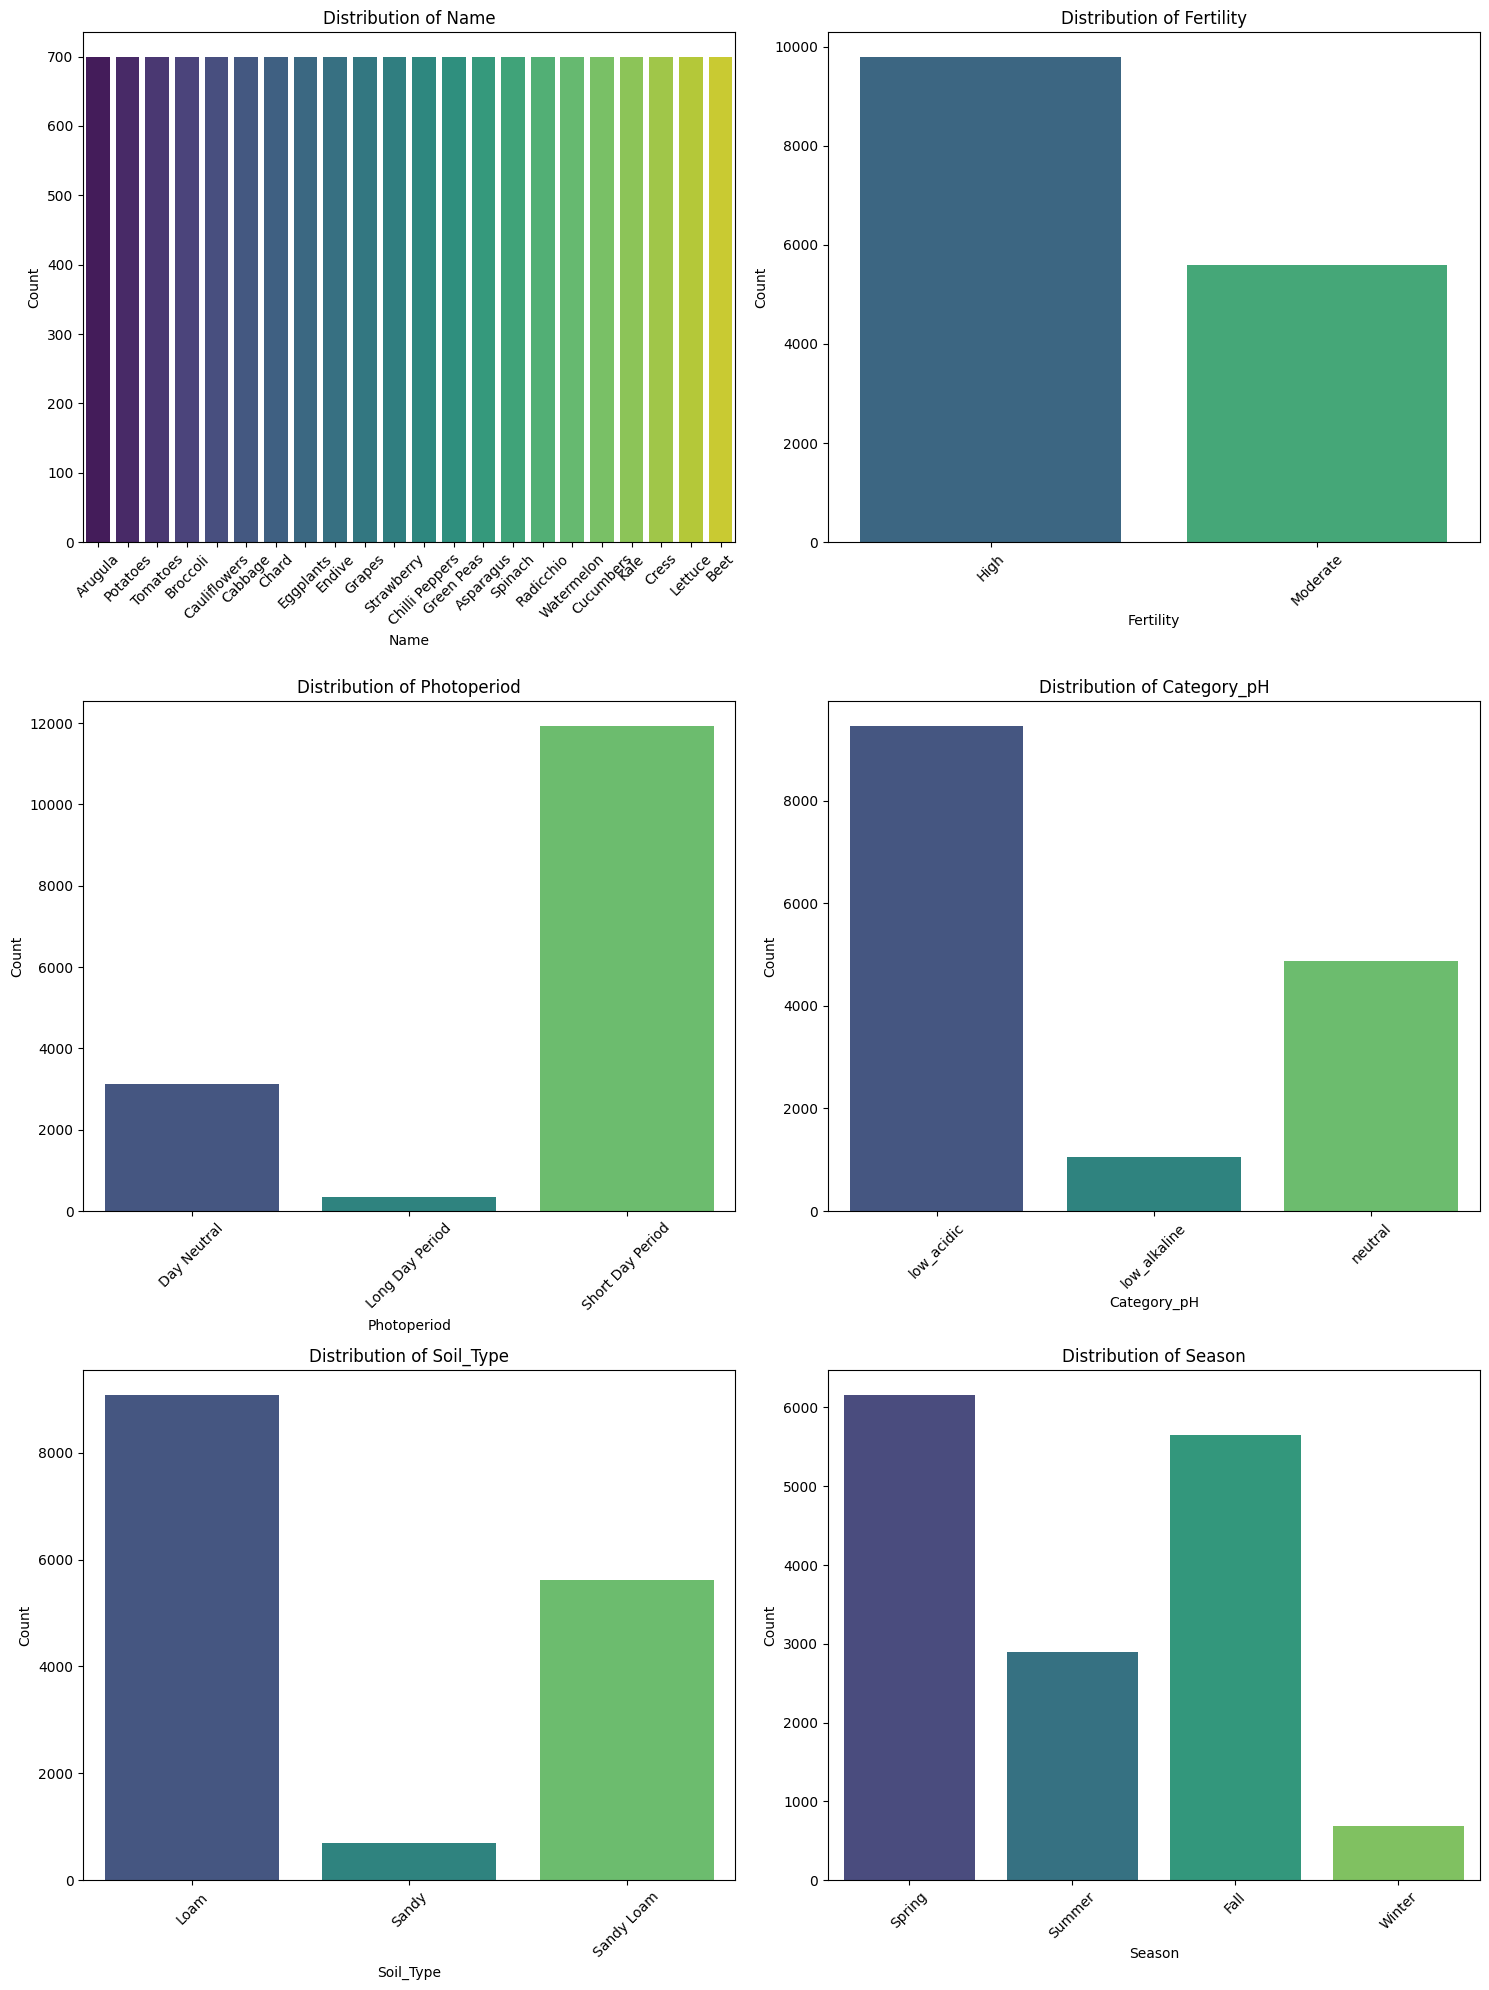

In [ ]:
# Daftar kolom kategorikal
categorical_cols = ['Name', 'Fertility', 'Photoperiod', 'Category_pH', 'Soil_Type', 'Season']

# Iterasi untuk setiap kolom kategorikal
plt.figure(figsize=(15, 20))

for i, cat_col in enumerate(categorical_cols, 1):

    dist_df = data.groupBy(cat_col).agg(count("*").alias("count")).toPandas()

    # Buat subplot untuk setiap kolom
    plt.subplot(3, 2, i)
    sns.barplot(x=cat_col, y="count", data=dist_df, palette="viridis")
    plt.title(f"Distribution of {cat_col}")
    plt.xlabel(cat_col)
    plt.ylabel("Count")
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

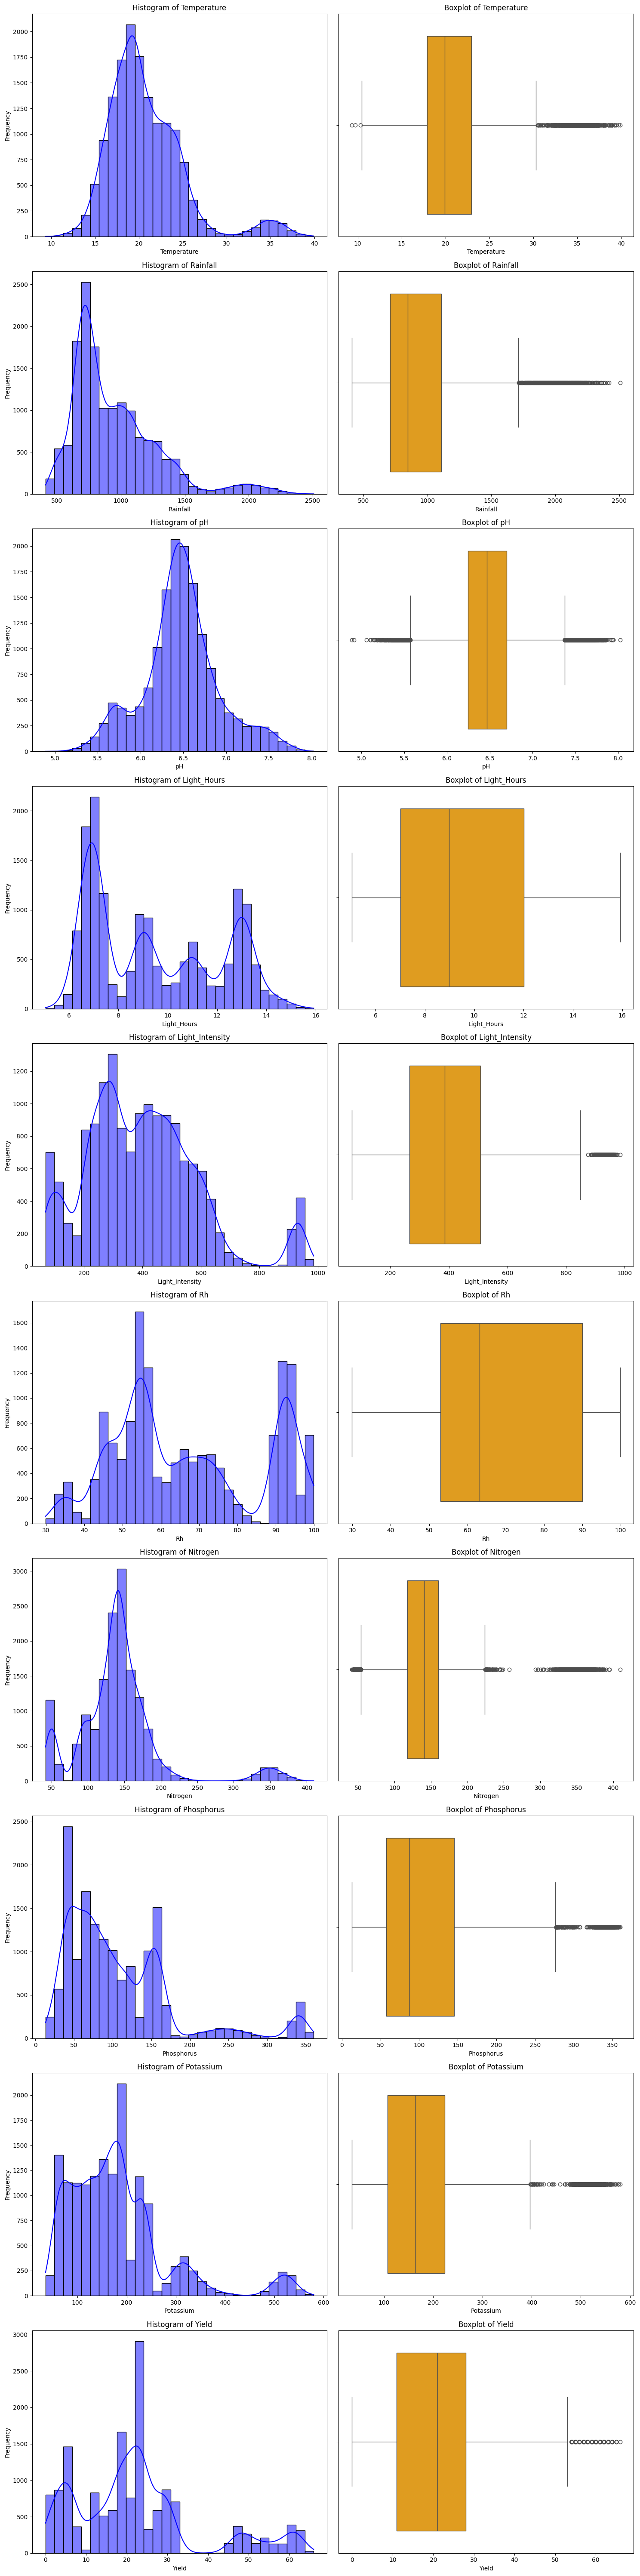

In [ ]:
# Iterasi untuk setiap kolom numerik
plt.figure(figsize=(15, len(numeric_columns) * 6))

for i, num_col in enumerate(numeric_columns, 1):

    num_data = data.select(num_col).toPandas()

    # Plot Histogram
    plt.subplot(len(numeric_columns), 2, 2 * i - 1)
    sns.histplot(num_data[num_col], bins=30, kde=True, color="blue")
    plt.title(f"Histogram of {num_col}")
    plt.xlabel(num_col)
    plt.ylabel("Frequency")

    # Plot Boxplot
    plt.subplot(len(numeric_columns), 2, 2 * i)
    sns.boxplot(x=num_data[num_col], color="orange")
    plt.title(f"Boxplot of {num_col}")
    plt.xlabel(num_col)

plt.tight_layout()
plt.show()

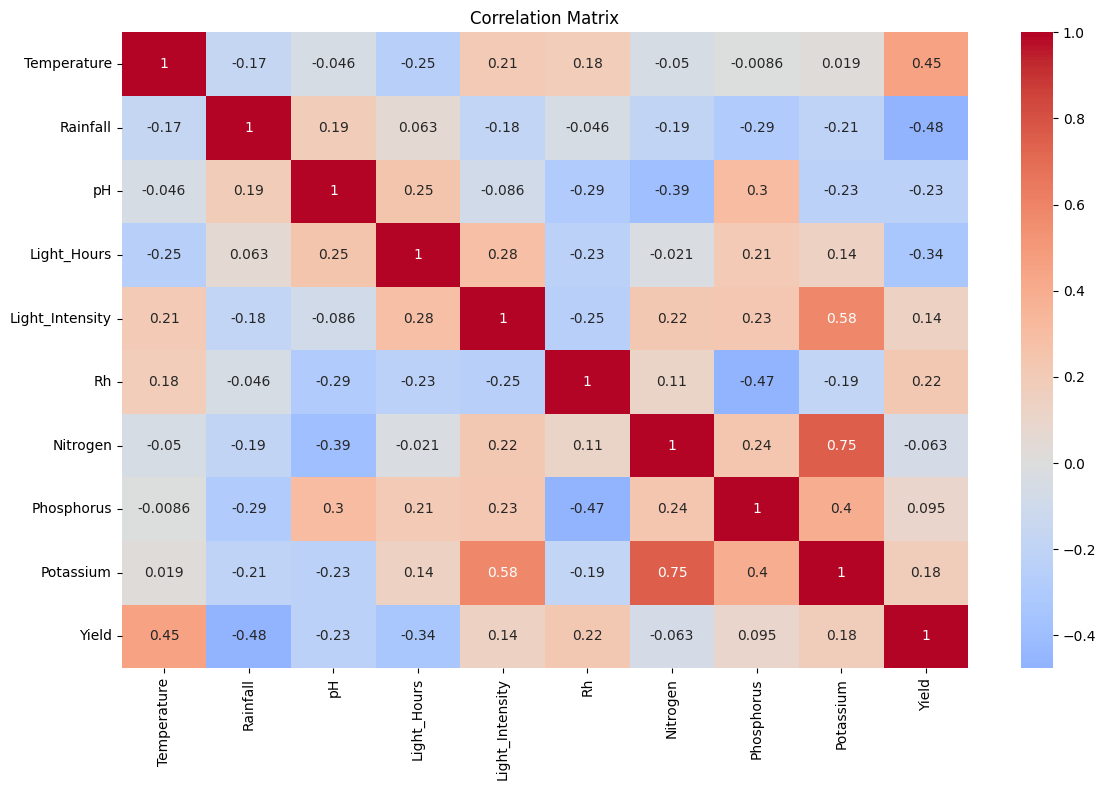

In [ ]:
# Analisis Korelasi
numeric_pdf = data.select(numeric_columns).toPandas()
correlation_matrix = numeric_pdf.corr()

# Plot correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()


In [ ]:
# Split data
train_data, test_data = data.randomSplit([0.8, 0.2], seed=42)

In [ ]:
# Seleksi fitur menggunakan Random Forest
# Menyiapkan assembler untuk fitur numerik
feature_assembler = VectorAssembler(
    inputCols=[col for col in numeric_columns if col != "Yield"],
    outputCol="numeric_features"
)

In [ ]:
# Menyiapkan data untuk seleksi fitur
feature_selection_data = feature_assembler.transform(train_data)

In [ ]:
# Membuat model Random Forest untuk seleksi fitur
rf_selector = RandomForestRegressor(
    featuresCol="numeric_features",
    labelCol="Yield",
    numTrees=100,
    maxDepth=10,
    seed=42
)

In [ ]:
# Melatih model untuk seleksi fitur
feature_selection_model = rf_selector.fit(feature_selection_data)

In [ ]:
# Mendapatkan skor
feature_importance = feature_selection_model.featureImportances
feature_importance_dict = {name: float(importance)
                         for name, importance in zip(numeric_columns, feature_importance)}

In [ ]:
# Mengurutkan dan mencetak skor
print("\nSkor Kepentingan Fitur:")
sorted_features = sorted(feature_importance_dict.items(),
                        key=lambda x: x[1],
                        reverse=True)
for feature, importance in sorted_features:
    print(f"{feature}: {importance:.4f}")


Skor Kepentingan Fitur:
Rainfall: 0.2196
Phosphorus: 0.1678
Light_Hours: 0.1350
Rh: 0.1121
Potassium: 0.1120
Nitrogen: 0.1055
Temperature: 0.0628
Light_Intensity: 0.0573
pH: 0.0279


In [ ]:
# Memilih fitur-fitur penting
selected_numeric_features = [feature for feature, importance
                           in sorted_features if importance > 0.01]
print(f"\nFitur numerik yang terpilih: {selected_numeric_features}")


Fitur numerik yang terpilih: ['Rainfall', 'Phosphorus', 'Light_Hours', 'Rh', 'Potassium', 'Nitrogen', 'Temperature', 'Light_Intensity', 'pH']


In [ ]:
# Encoding kategorikal features
indexers = [StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
           for col in categorical_cols]

In [ ]:
# Standardisasi fitur numerik
assembler_numeric = VectorAssembler(
    inputCols=[col for col in numeric_columns if col != "Yield"],
    outputCol="numeric_features"
)
scaler = StandardScaler(
    inputCol="numeric_features",
    outputCol="scaled_numeric_features",
    withStd=True,
    withMean=True
)

In [ ]:
final_assembler = VectorAssembler(
    inputCols=["scaled_numeric_features"] +
             [f"{col}_index" for col in categorical_cols],
    outputCol="features"
)

In [ ]:
# Konfigurasi model Random Forest
rf_model = RandomForestRegressor(
    featuresCol="features",
    labelCol="Yield",
    numTrees=100,
    maxDepth=10,
    maxBins=32,
    minInstancesPerNode=1,
    seed=42
)

In [ ]:
# Membuat pipeline
pipeline = Pipeline(stages=[
    *indexers,
    assembler_numeric,
    scaler,
    final_assembler,
    rf_model
])

In [ ]:
# Konfigurasi parameter grid untuk cross validation
paramGrid = ParamGridBuilder() \
    .addGrid(rf_model.numTrees, [50, 100]) \
    .addGrid(rf_model.maxDepth, [5, 10]) \
    .build()

In [ ]:
# Menyiapkan cross validator
crossval = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=RegressionEvaluator(labelCol="Yield"),
    numFolds=5
)

In [ ]:
# Melatih model
print("\nMelatih model...")
start_time = time.time()
model = crossval.fit(train_data)


Melatih model...


In [ ]:
# Membuat prediksi
predictions = model.transform(test_data)

# Menghitung metrik evaluasi
evaluator_rmse = RegressionEvaluator(labelCol="Yield",
                                    predictionCol="prediction",
                                    metricName="rmse")
evaluator_r2 = RegressionEvaluator(labelCol="Yield",
                                  predictionCol="prediction",
                                  metricName="r2")
evaluator_mae = RegressionEvaluator(labelCol="Yield",
                                   predictionCol="prediction",
                                   metricName="mae")

rmse = evaluator_rmse.evaluate(predictions)
r2 = evaluator_r2.evaluate(predictions)
mae = evaluator_mae.evaluate(predictions)

training_time = time.time() - start_time

print(f"\nPelatihan selesai dalam {training_time:.2f} detik")
print(f"RMSE: {rmse:.4f}")
print(f"R2: {r2:.4f}")
print(f"MAE: {mae:.4f}")



Pelatihan selesai dalam 723.10 detik
RMSE: 1.1546
R2: 0.9944
MAE: 0.6395



Membuat visualisasi...


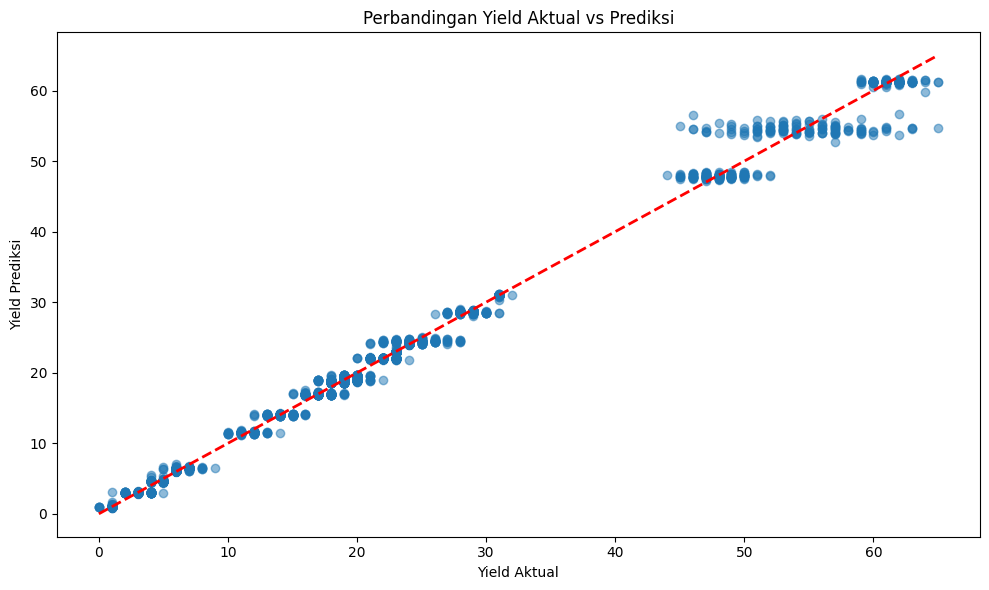

In [ ]:
# Membuat visualisasi actual vs predicted
print("\nMembuat visualisasi...")
plt.figure(figsize=(10, 6))
predictions_pd = predictions.select("Yield", "prediction").toPandas()
plt.scatter(predictions_pd["Yield"], predictions_pd["prediction"], alpha=0.5)
plt.plot([predictions_pd["Yield"].min(), predictions_pd["Yield"].max()],
         [predictions_pd["Yield"].min(), predictions_pd["Yield"].max()],
         'r--', lw=2)
plt.xlabel("Yield Aktual")
plt.ylabel("Yield Prediksi")
plt.title("Perbandingan Yield Aktual vs Prediksi")
plt.tight_layout()
plt.show()

In [ ]:
pred_pd = predictions.select("Yield", "prediction").toPandas()

In [ ]:
pred_pd['residuals'] = pred_pd['Yield'] - pred_pd['prediction']

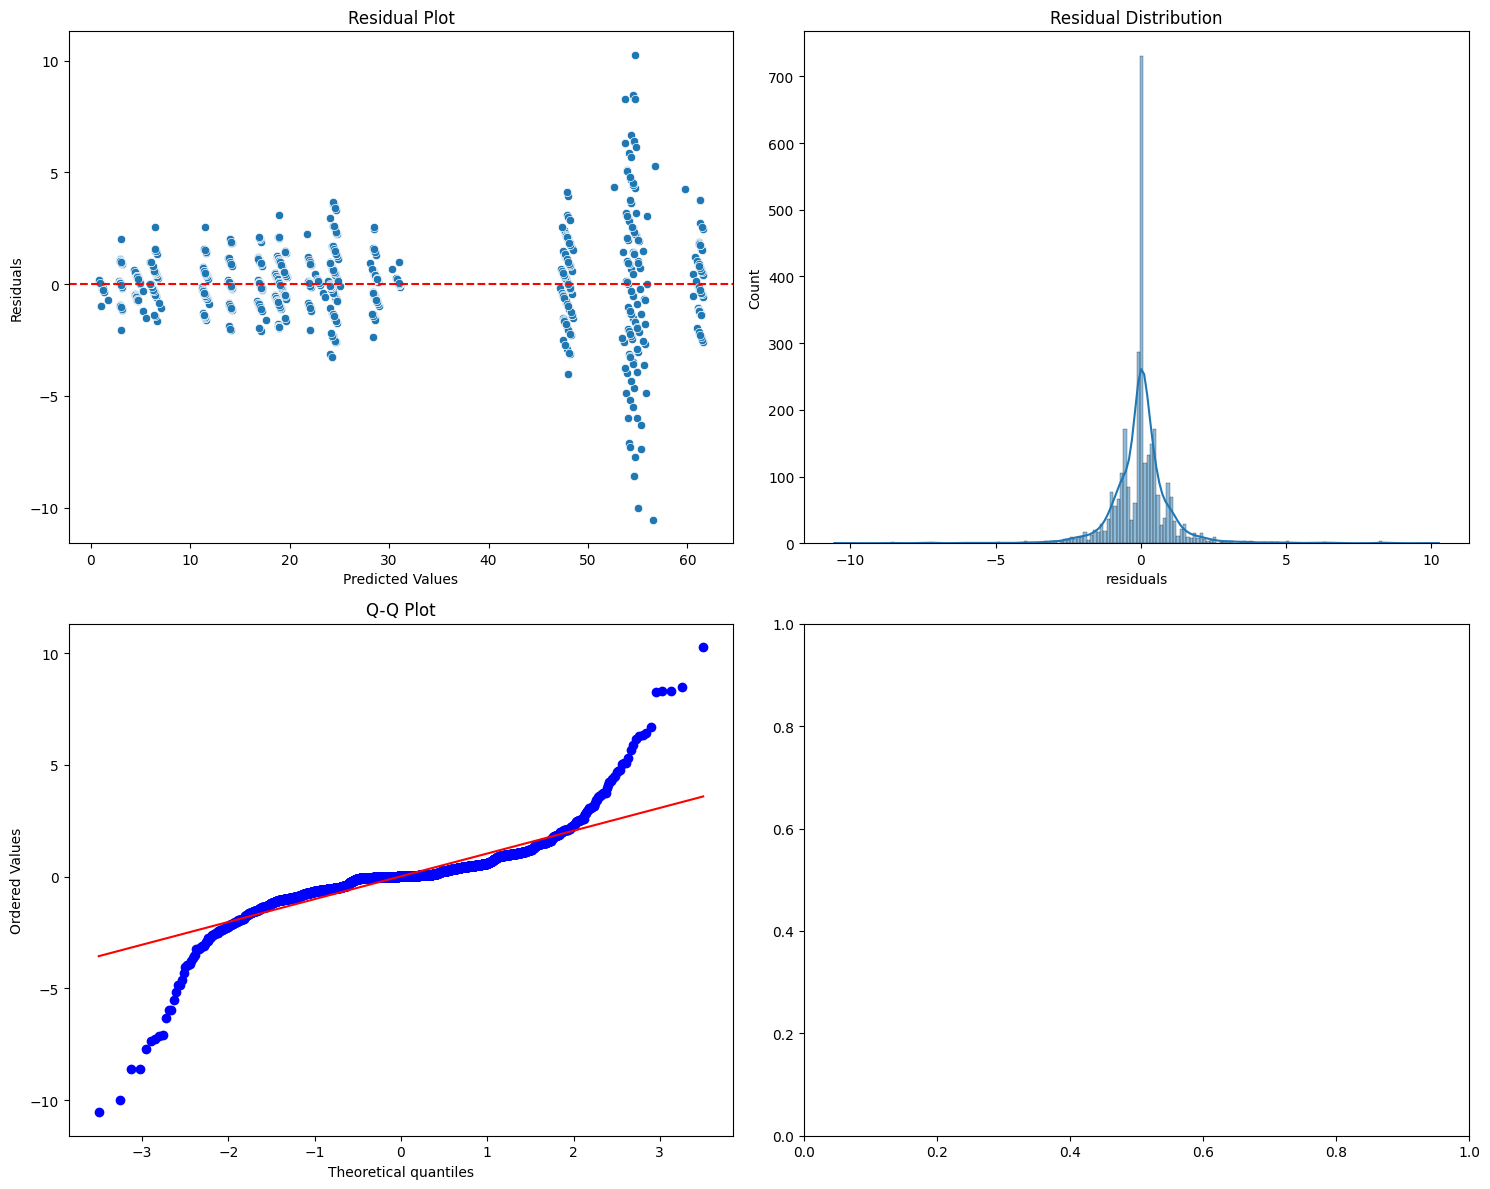

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# Residual Plot
sns.scatterplot(data=pred_pd, x='prediction', y='residuals', ax=axes[0,0])
axes[0,0].axhline(y=0, color='r', linestyle='--')
axes[0,0].set_title('Residual Plot')
axes[0,0].set_xlabel('Predicted Values')
axes[0,0].set_ylabel('Residuals')

# Residual Distribution
sns.histplot(data=pred_pd, x='residuals', kde=True, ax=axes[0,1])
axes[0,1].set_title('Residual Distribution')

# Q-Q Plot
from scipy import stats
stats.probplot(pred_pd['residuals'], dist="norm", plot=axes[1,0])
axes[1,0].set_title('Q-Q Plot')

plt.tight_layout()
plt.show()

In [ ]:
# Buat directory untuk menyimpan model
model_dir = "Model_UAS_4595"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:
# Buat metadata model tanpa objek kompleks
model_metadata = {
    'feature_names': numeric_columns[:-1] + categorical_cols,
    'target_name': 'Yield',
    'model_performance': {
        'rmse': float(rmse),
        'r2': float(r2),
        'mae': float(mae)
    },
    'best_parameters': {
        'numTrees': rf_model.getNumTrees(),
        'maxDepth': rf_model.getMaxDepth(),
        'minInstancesPerNode': rf_model.getMinInstancesPerNode()
    },
    'feature_importance': {
        'features': selected_numeric_features,
        'importance_scores': [float(importance) for _, importance in sorted_features
                         if importance > 0.01]
    }
}

# Simpan semua informasi dalam satu file JSON
with open(f"{model_dir}/model_metadata.json", 'w') as f:
    json.dump(model_metadata, f, indent=4)

print("Metadata dan feature importance berhasil disimpan dalam satu file.")


Metadata dan feature importance berhasil disimpan dalam satu file.
